<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [34]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr

from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
wgs_dia_directory = '../sfari/data/diaimmune'
wgs_ibd_directory = '../sfari/data/sra_ibd_shotgun/Combined'
wgs_asd_directory = '../sfari/data/sra_shotgun/Combined'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)

threshold = 100  # determined based on bimodality of count distribution

%matplotlib inline

Get pathways

In [35]:
pwy_summary = pd.read_csv('../results/kegg_counts.csv')
pwy_summary = pwy_summary.pivot(index='index', columns='disease_intersection', values='KEGG_counts')
pwy_summary = pwy_summary.fillna(0)

asd_ibd = np.log(pwy_summary['asd_'] / pwy_summary['asd_ibd'])
asd_t1d = np.log(pwy_summary['asd_'] / pwy_summary['asd_t1d'])

asd_pwys = set(asd_ibd.loc[asd_ibd > 0].index) | set(asd_t1d.loc[asd_t1d > 0].index)

Get microbes

In [101]:
sname = 'asd_'
mapping = pd.read_csv(f'../results/{sname}_taxa_set.csv') 
mapping['genome'] = mapping['genome'].astype(str)
mapping = mapping.set_index('genome')
gotus = list(map(str, mapping.index))

# load ASD data
posterior_name = 'age_sex_matched_posterior'
wgs_fname = f'{wgs_asd_directory}/{posterior_name}/ogus_differentials-v4.nc'
wgs_asd_diffs = extract_differentials(wgs_fname)
wgs_asd_stats = ranking(wgs_asd_diffs, reference_percentile=95)
wgs_asd_stats = pd.merge(wgs_asd_stats, mapping, left_index=True, right_index=True)

#gotus = list(set(gotus) & set(wgs_asd_stats.loc[wgs_asd_stats['tstat'] > 0].index))

In [105]:
!ls -lhrt ../sfari/data/sra_shotgun/Combined/age_sex_matched_posterior

total 67G
-rw-rw-r-- 1 jmorton jmorton  33G Jun  2 19:45 differential_posterior.nc
-rw-rw-r-- 1 jmorton jmorton  12G Jun 25 19:34 viral_differentials.nc
-rw-rw-r-- 1 jmorton jmorton 9.4G Jul 30 02:08 ogus_differentials-v2.nc
-rw-rw-r-- 1 jmorton jmorton 2.6G Jul 30 13:39 viral_differentials-v2.nc
-rw-rw-r-- 1 jmorton jmorton 2.4G Sep 13 19:52 viral_differentials-v3.nc
-rw-rw-r-- 1 jmorton jmorton 6.9G Sep 13 21:14 ogus_differentials-v3.nc
-rw-rw-r-- 1 jmorton jmorton 2.3G Oct 25 00:59 ogus_differentials-v4.nc


In [107]:
wgs_asd_stats.sort_values('tstat')

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,kingdom,phylum,class,order,family,genus,species,GOTU
1550024,0.503043,0.072844,0.389318,0.499632,0.626149,94.802063,188.457038,-37.152868,1.329399e-131,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruthenibacterium,Ruthenibacterium lactatiformans,G001481375
883156,0.513556,0.090685,0.370238,0.512027,0.663318,62.447120,121.597478,-27.524918,3.019579e-94,Bacteria,Firmicutes,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,Veillonella seminalis,G000315505
1121303,0.521689,0.100313,0.367934,0.524305,0.691479,51.844082,99.377340,-23.261716,2.920897e-76,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium,[Clostridium] cellobioparum,G000621505
1702287,0.506719,0.143214,0.273160,0.518622,0.735463,24.705515,48.755870,-18.384019,4.043874e-55,Bacteria,Firmicutes,Negativicutes,Veillonellales,Veillonellaceae,Negativicoccus,Negativicoccus massiliensis,G900155405
891974,0.506937,0.149455,0.258553,0.508426,0.754048,22.695070,44.768983,-17.587086,1.134437e-51,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,NaN,Plautia stali symbiont,G000180175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155892,1.408789,0.327369,0.897836,1.413666,1.906848,13.145334,9.330947,47.067866,5.832414e-165,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Caulobacter,Caulobacter vibrioides,G001449105
1123499,1.340683,0.290676,0.873609,1.330619,1.809641,15.867456,11.835355,48.323278,7.649414e-169,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Vitreoscilla,Vitreoscilla stercoraria,G000382305
1262870,1.047456,0.163737,0.803824,1.041440,1.314681,39.069879,37.299794,49.969658,7.933672e-174,Bacteria,Firmicutes,Negativicutes,Veillonellales,Veillonellaceae,Dialister,Dialister sp. CAG:486,G000434475
1643450,2.247354,0.451070,1.547579,2.254792,3.024542,11.045454,4.914870,71.341149,3.087671e-229,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Hyphomicrobiaceae,Devosia,Devosia sp. H5989,G001185205


Get KEGGs

In [92]:
pathway_name_file = f'{kegg_dir}/pathway_name.txt'
pathway_to_ko_file = f'{kegg_dir}/pathway-to-ko.txt'
columns = ['Pathway', 'KO']
pwy2kegg = read_kegg_dict(pathway_to_ko_file, columns)
pwy_name = pd.read_table(pathway_name_file, header=None)
pwy_name.columns = ['Pathway', 'Name']
pwy2kegg = pd.merge(pwy2kegg, pwy_name, left_on='Pathway', right_on='Pathway')

Get microbe / kegg mappings

In [93]:
# get microbe / kegg mappings
ko_ogu = get_genomic_data(f'{wgs_asd_directory}/table_func.biom')
ko_ogu = ko_ogu.reindex(index=gotus).dropna()
ko_ogu = ko_ogu.loc[:, ko_ogu.sum(axis=0) > 1]
# filter out pathways
idx = pwy2kegg['Name'].apply(lambda x: x in asd_pwys)
pwy2kegg = pwy2kegg.loc[idx]
# filter out keggs
idx = pwy2kegg['KO'].apply(lambda x: x in set(ko_ogu.columns))
pwy2kegg = pwy2kegg.loc[idx]

In [94]:
microbe_kegg_edges = pd.melt(frame=ko_ogu.reset_index(), id_vars='index', var_name='KO')
microbe_kegg_edges = microbe_kegg_edges.loc[microbe_kegg_edges['value'] > 0]
microbe_kegg_edges['value'] = microbe_kegg_edges['value'] > 0
microbe_kegg_edges = microbe_kegg_edges.rename(columns={'index': 'genome'})
microbe_kegg_edges = pd.merge(microbe_kegg_edges, mapping, left_on='genome', right_index=True)

In [95]:
microbe_kegg_edges = pd.merge(microbe_kegg_edges, pwy2kegg, left_on='KO', right_on='KO')
microbe_pwy_edges = microbe_kegg_edges[['species', 'Name']].drop_duplicates()

In [96]:
import networkx as nx
from networkx.drawing.layout import bipartite_layout

microbe_pwy_edges['species'] = microbe_pwy_edges['species'].apply(
    lambda x: x.replace(']', '').replace('[', ''))
microbe_pwy_edges = microbe_pwy_edges.sort_values('species')

G = nx.from_pandas_edgelist(microbe_pwy_edges, source='species', target='Name')

#taxa = list(microbe_pwy_edges['species'].value_counts().index)
taxa = list(microbe_pwy_edges['species'].value_counts().sort_index().index)
keggs = list(microbe_pwy_edges['Name'].value_counts().index)

pos = bipartite_layout(G, taxa)
pos = pd.DataFrame(pos).T

#pos.loc[taxa, 1] = pos[1].head(len(taxa)).values
#pos.loc[keggs, 1] = pos[1].tail(len(keggs)).values

taxa_pos = pos.head(len(taxa))
kegg_pos = pos.tail(len(keggs))

taxa_pos = taxa_pos.sort_index()
taxa_pos[1] = taxa_pos[1].sort_values().values

kegg_order = [
    'Ether lipid metabolism', 
    'Lipoic acid metabolism',
    'Sulfur metabolism',    
    'Tyrosine metabolism',
    'Histidine metabolism',
    'Tryptophan metabolism',
    'Taurine and hypotaurine metabolism',
    'beta-Alanine metabolism',
    'Amino sugar and nucleotide sugar metabolism',
    'Choline metabolism in cancer',
    'Sphingolipid metabolism',
    'Starch and sucrose metabolism', 
    'Galactose metabolism', 
    'Inositol phosphate metabolism', 
    'Nicotinate and nicotinamide metabolism', 
    'Porphyrin and chlorophyll metabolism'
]

#kegg_pos = kegg_pos.loc[kegg_order]
kegg_pos[1] = kegg_pos[1].sort_values().values
pos = pd.concat((taxa_pos, kegg_pos))

<ipython-input-96-18673e77881e>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_pos[1] = kegg_pos[1].sort_values().values


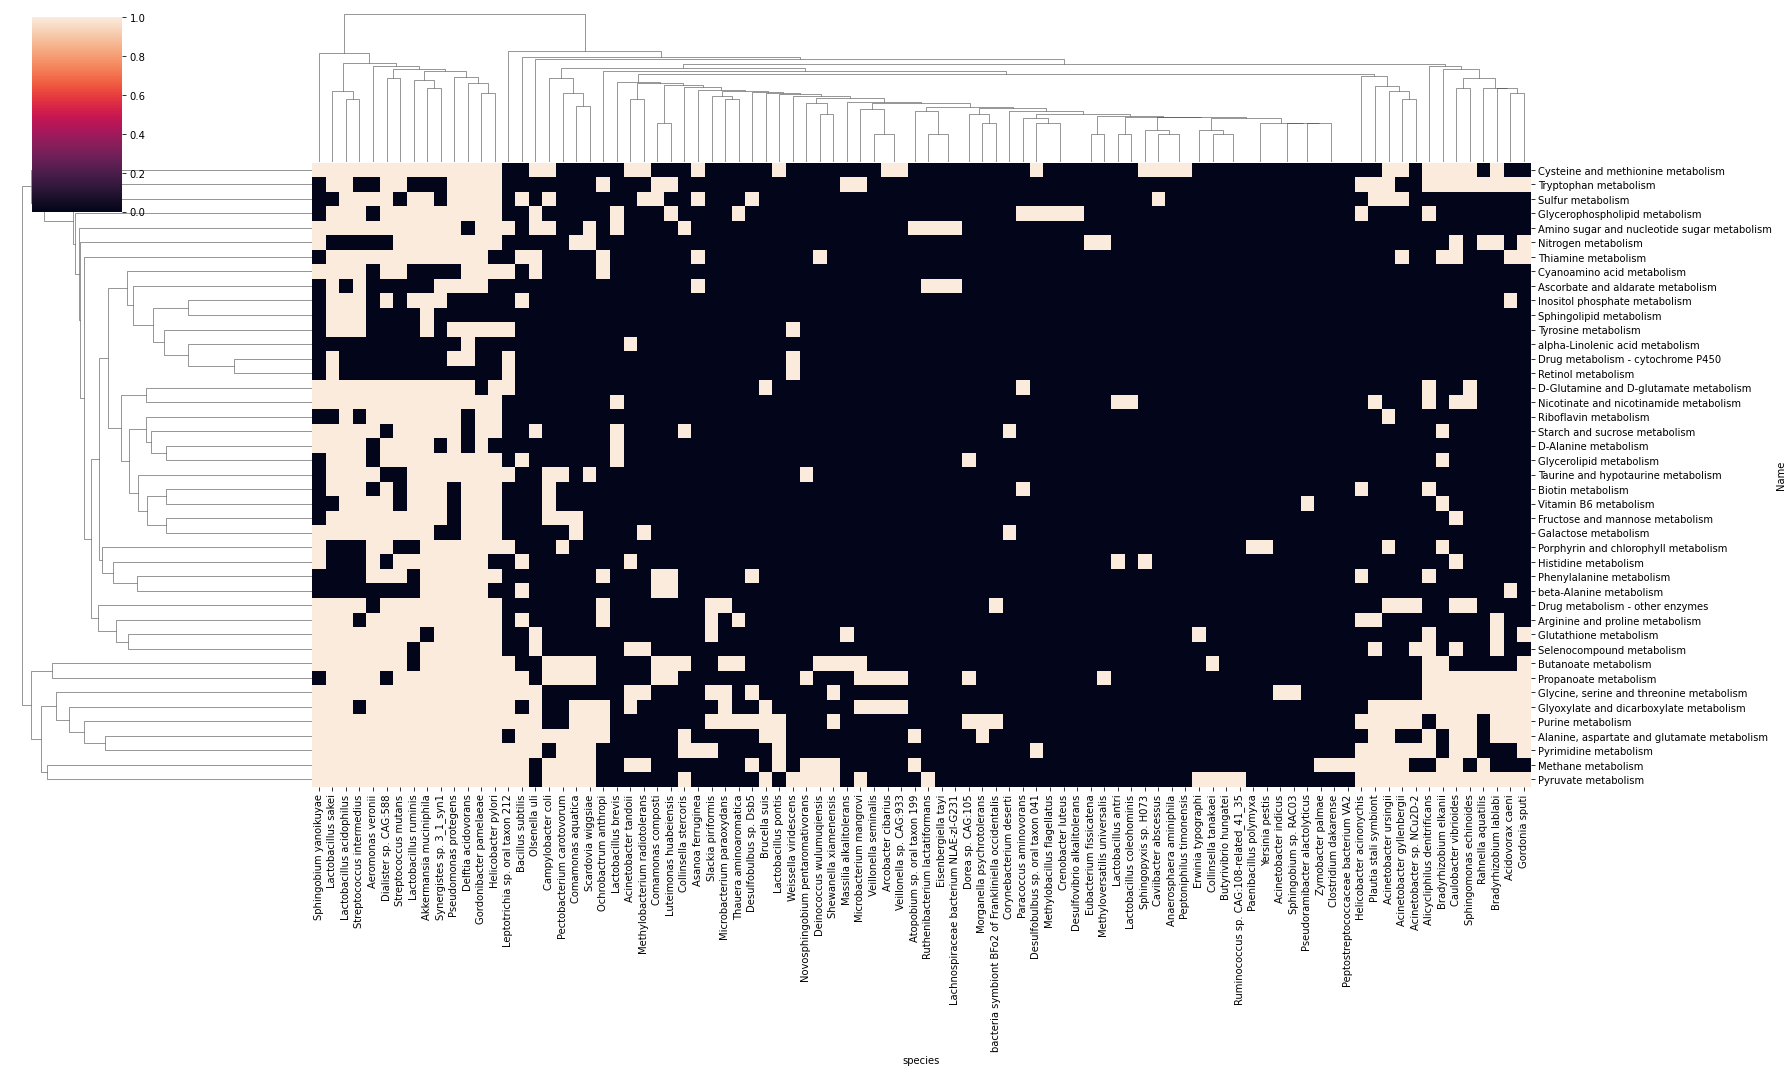

In [108]:
hm = microbe_pwy_edges.copy()
hm['count'] = 1
hm = pd.pivot(data=hm, index='species', columns='Name', values='count')
hm = hm.fillna(0)
sns.clustermap(hm.T, figsize=(25, 15))

(-0.5516666666666667,
 1.073888888888889,
 -0.6095833333333334,
 0.6095833333333334)

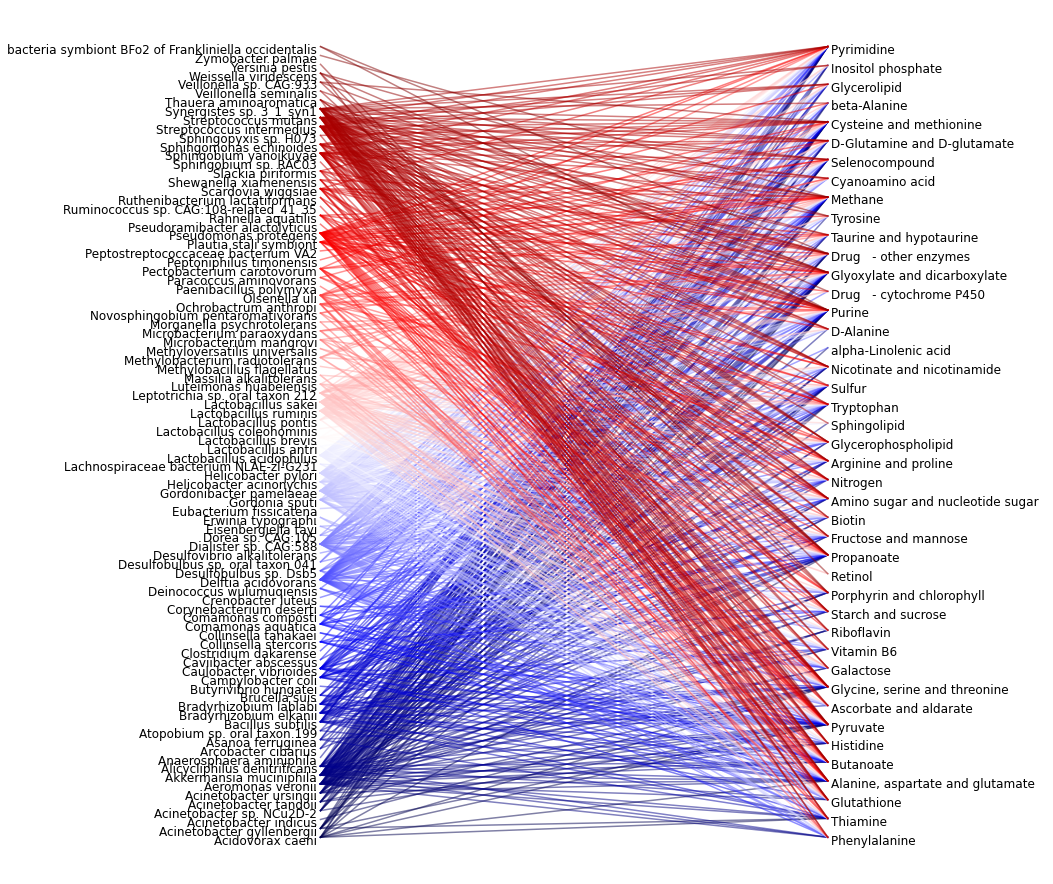

In [98]:
fig, ax = plt.subplots(figsize=(10, 16))

#ax.scatter(pos[0], pos[1])
#palette = pd.Series(sns.color_palette('viridis'), index=taxa)
cmap = matplotlib.cm.get_cmap('seismic')
palette = pd.DataFrame(cmap(np.linspace(0, 1, len(taxa))), index=taxa)

#for i in microbe_pwy_edges.index:
#    x, y = microbe_pwy_edges.loc[i, 'species'], microbe_pwy_edges.loc[i, 'Name']
#    ax.plot([pos.loc[x, 0], pos.loc[y, 0]], [pos.loc[x, 1], pos.loc[y, 1]], 
#            c=palette.loc[x], alpha=0.5)

for i in microbe_pwy_edges.index:
    x, y = microbe_pwy_edges.loc[i, 'species'], microbe_pwy_edges.loc[i, 'Name']
    ax.plot([pos.loc[x, 0], pos.loc[y, 0]], [pos.loc[x, 1], pos.loc[y, 1]], 
            c=palette.loc[x], alpha=0.5)

for i in pos.index:
    if i in taxa:
        ha='right'
        dx, dy = -.01, -0.01
    else:
        ha='left'
        dx, dy = .01, -0.01
    tx = i.replace('metabolism', ' ')
    #tx = tx.replace('and', '+')
    #tx = tx.replace('  ', ' ')
    #tx = tx.replace('in cancer', ' ')
    #tx = tx.replace('+ nucleotide sugar', ' ')
    ax.annotate(tx, (pos.loc[i, 0] + dx, pos.loc[i, 1] + dy), fontsize=12, ha=ha)
    
ax.set_xticklabels([])
_ = ax.set_yticklabels([])

ax.axis('off')
#_ = ax.set_xlim([-3, 1])

In [ ]:
taxa_pos = pos.head(len(taxa))
kegg_pos = pos.tail(len(keggs))

taxa_pos = taxa_pos.sort_index()
taxa_pos[1] = taxa_pos[1].sort_values().values

In [ ]:
kegg_pos.index

In [ ]:
pos

In [ ]:
cmap(np.linspace(0, 1, len(taxa)))

In [ ]:
palette